In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder,RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from matplotlib.colors import Normalize
from catboost import CatBoostRegressor

df = pd.read_csv("./test/input/previsao_de_renda.csv")  # Exemplo de carregamento de dados
df = df.drop(columns=['Unnamed: 0','id_cliente','data_ref'])
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].astype(int)

# Step 1: Select relevant features for imputation
cat_features = [ 'tipo_renda', 'estado_civil',
                           'tipo_residencia', 'posse_de_veiculo', 'posse_de_imovel','sexo']

num_features = ['tempo_emprego', 'idade', 'qt_pessoas_residencia', 'qtd_filhos', 'renda']

# Step 2: Convert categorical features into dummies
df_dummies = pd.get_dummies(df[cat_features], drop_first=True)
df_numeric = df[num_features]

# Step 4: Standardize numeric columns (optional but improves KNN performance)
scaler = MinMaxScaler()
df_impute_scaled = pd.DataFrame(scaler.fit_transform(df[num_features]), columns=df_numeric.columns)

# Step 3: Add 'tempo_emprego' column (including missing values)
df_dummies_numeric = pd.concat([df_dummies, df_impute_scaled], axis=1)

# Step 5: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)  # Using 5 nearest neighbors
df_imputed = pd.DataFrame(imputer.fit_transform(df_dummies_numeric), columns=df_dummies_numeric.columns)

for col in df_dummies.columns:
    df_imputed[col] = df_imputed[col] > 0.5  # Convert back to boolean

In [2]:
todrop = ['tipo_renda_Bolsista',
'tipo_residencia_Comunitário',
'tipo_residencia_Estúdio',
'tipo_residencia_Com os pais',
'estado_civil_Separado',
'estado_civil_União',
'estado_civil_Viúvo']


In [3]:
X = df_imputed.drop(columns=['renda'])  # Features
y = df_imputed['renda']  # Target variable

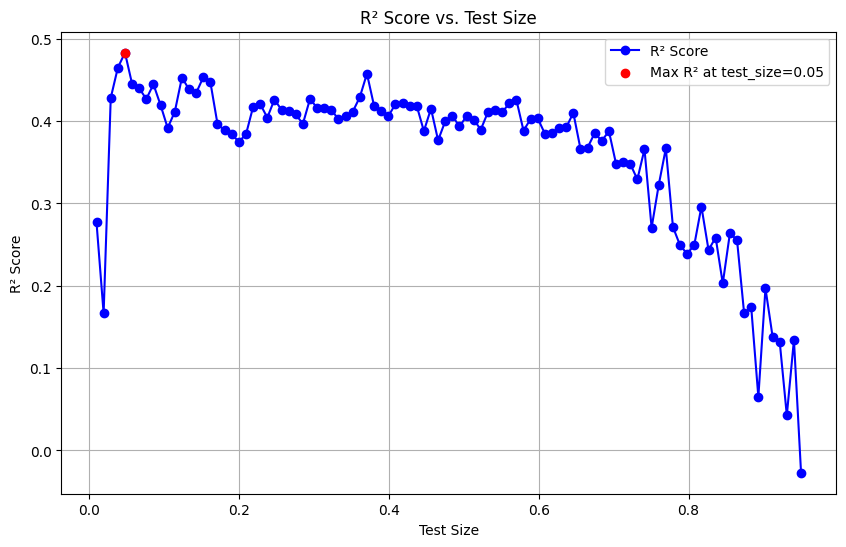

In [4]:
test_sizes = np.linspace(0.01, 0.95, 100)  # test_size from 0.1 to 0.4
r2_scores = []
num_features2 = ['tempo_emprego', 'idade', 'qt_pessoas_residencia', 'qtd_filhos']
# Loop through different test sizes
for test_size in test_sizes:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
                      
        # Initialize models
        reg1 = XGBRegressor()
        reg2 = Pipeline([
            ('scaler', RobustScaler()),  # Normalize the data for MLP
            ('mlp', MLPRegressor(max_iter=5000))
        ])
        
        # Create ensemble with VotingRegressor
        reg = VotingRegressor(estimators=[('xgb', reg1), ('mlp', reg2)])
        
        # Train model
        reg.fit(X_train, y_train)
        
        # Evaluate model
        r2_score_value = reg.score(X_test, y_test)
        r2_scores.append(r2_score_value)

max_r2_score = max(r2_scores)
max_r2_index = r2_scores.index(max_r2_score)
best_test_size = test_sizes[max_r2_index]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, r2_scores, marker='o', linestyle='-', color='b', label="R² Score")
plt.scatter(best_test_size, max_r2_score, color='red', zorder=5, label=f'Max R² at test_size={best_test_size:.2f}')
plt.title('R² Score vs. Test Size')
plt.xlabel('Test Size')
plt.ylabel('R² Score')
plt.grid(True)
plt.legend()
plt.show()

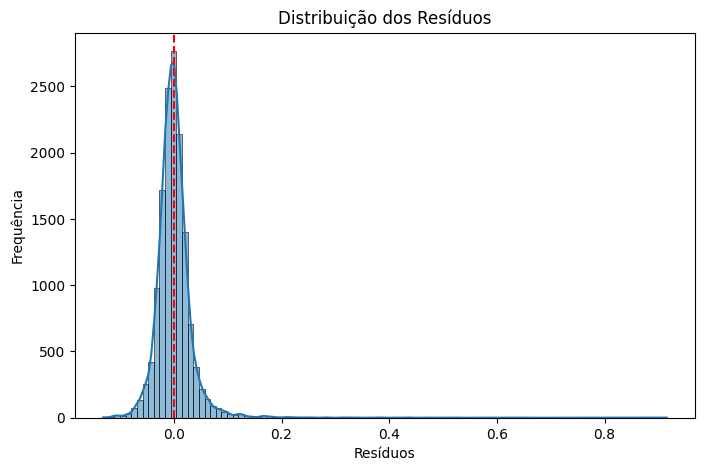

In [5]:
y_pred = reg.predict(X_test)
residuos = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuos, bins=100, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.show()

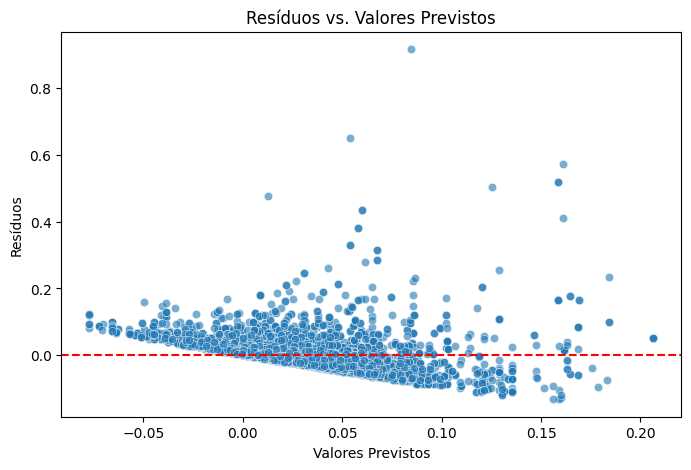

In [6]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Previstos')
plt.show()

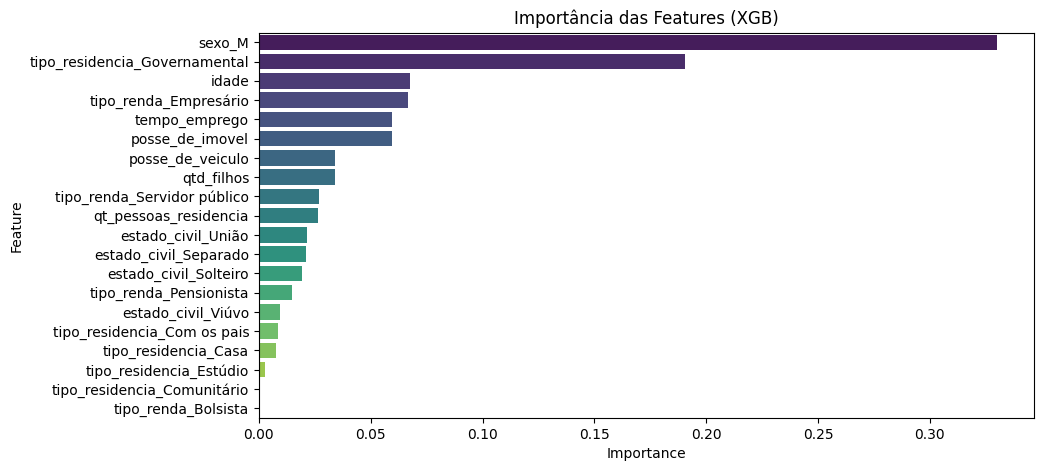

In [7]:
# Treina o modelo XGBRegressor separadamente
reg1.fit(X_train, y_train)

# Agora podemos acessar a importância das features
feature_importances = reg1.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette="viridis")
plt.title('Importância das Features (XGB)')
plt.show()

In [8]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.42, random_state=42)

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y, discrete_features='auto',random_state=42)

# Create a DataFrame with results
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# Print top features
print(mi_df)

                          Feature  Mutual_Information
16                  tempo_emprego            0.904212
17                          idade            0.583340
18          qt_pessoas_residencia            0.234069
15                         sexo_M            0.191178
19                     qtd_filhos            0.168491
0                posse_de_veiculo            0.146604
1                 posse_de_imovel            0.136724
3           tipo_renda_Empresário            0.113234
4          tipo_renda_Pensionista            0.097702
7           estado_civil_Solteiro            0.071845
10           tipo_residencia_Casa            0.066799
5     tipo_renda_Servidor público            0.056725
9              estado_civil_Viúvo            0.038092
6           estado_civil_Separado            0.038027
8              estado_civil_União            0.036382
11    tipo_residencia_Com os pais            0.033698
14  tipo_residencia_Governamental            0.033388
13        tipo_residencia_Es

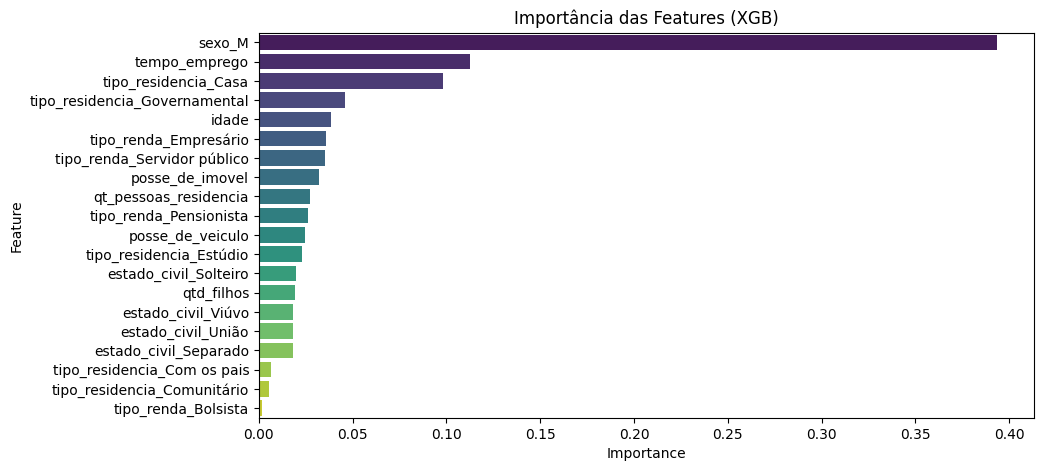

In [9]:
# Treina o modelo XGBRegressor separadamente
reg1.fit(X_train, y_train)

# Agora podemos acessar a importância das features
feature_importances = reg1.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette="viridis")
plt.title('Importância das Features (XGB)')
plt.show()

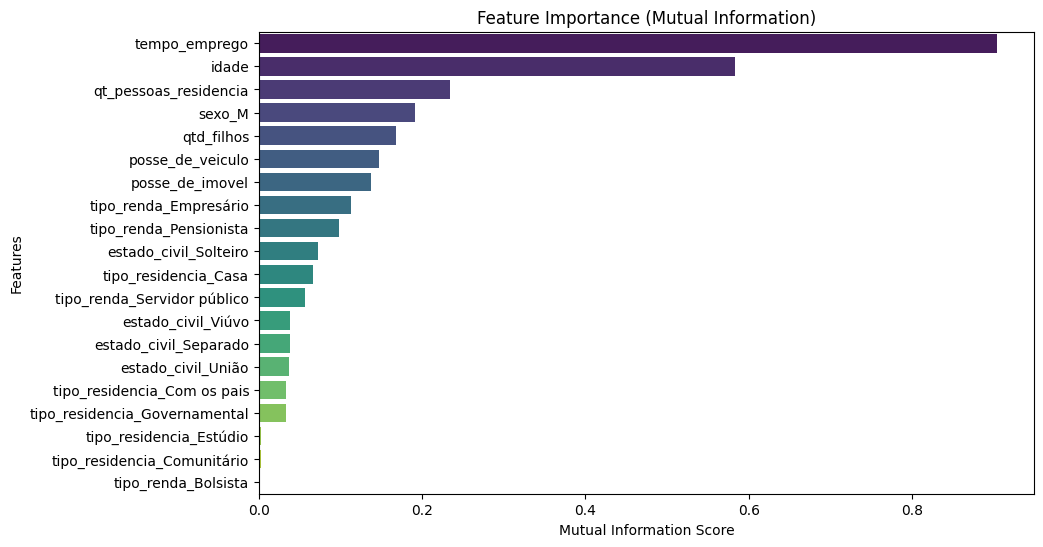

In [10]:
%matplotlib inline
# Sort features by importance
mi_df_sorted = mi_df.sort_values(by="Mutual_Information", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Mutual_Information", y="Feature", data=mi_df_sorted, palette="viridis")

# Labels and title
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance (Mutual Information)")
plt.show()

In [11]:
# Varying test_size values
test_sizes = np.linspace(0.01, 0.45, 50)  # test_size from 0.1 to 0.4
r2_scores = []

# Loop through different test sizes
for test_size in test_sizes:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Apply RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    reg1 = XGBRegressor()
    reg2 = Pipeline([
        ('scaler', RobustScaler()),  # Normalize the data for MLP
        ('mlp', MLPRegressor(max_iter=5000))
    ])
    
    # Create ensemble with VotingRegressor
    reg = VotingRegressor(estimators=[('xgb', reg1), ('mlp', reg2)])
    
    # Train model
    reg.fit(X_train_scaled, y_train)
    
    # Evaluate model
    r2_score_value = reg.score(X_test_scaled, y_test)
    r2_scores.append(r2_score_value)


: 

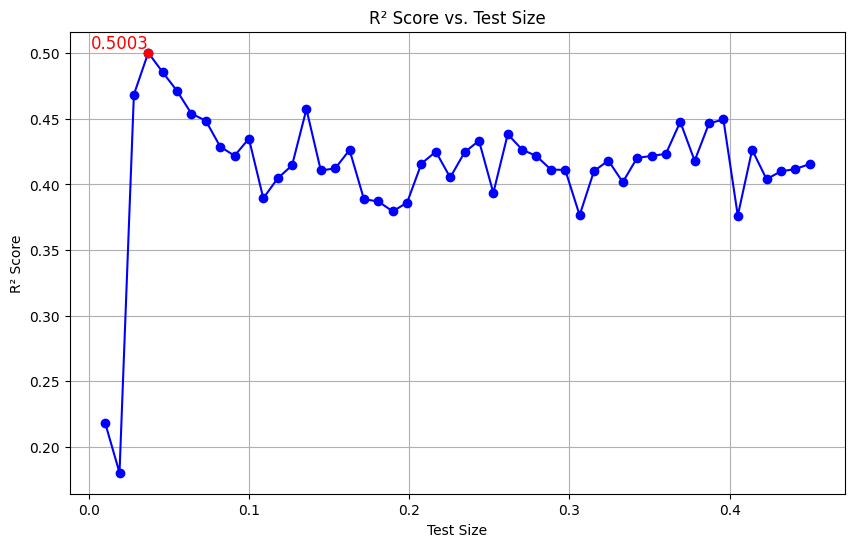

In [36]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, r2_scores, marker='o', linestyle='-', color='b')
plt.title('R² Score vs. Test Size')
plt.xlabel('Test Size')
plt.ylabel('R² Score')
plt.grid(True)

# Mark maximum R² value
max_r2_score = max(r2_scores)
max_r2_index = r2_scores.index(max_r2_score)
max_test_size = test_sizes[max_r2_index]
plt.scatter(max_test_size, max_r2_score, color='red', zorder=5)  # Mark the point with red
plt.text(max_test_size, max_r2_score, f'{max_r2_score:.4f}', color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.show()

In [ ]:
reg1 = CatBoostRegressor(cat_features=cat_features, verbose=0)
reg2 = Pipeline([
    ('scaler', RobustScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=5000))
])

ensemble_model = VotingRegressor(estimators=[('catboost', reg1), ('mlp', reg2)])
ensemble_model.fit(X_train, y_train)